# Introduction
This notebook illustrates how to use the Python package GalaxyDynamicsFromVc.
This package is built to analyse circular velocity ($V_c$) data of a given galaxy, and extract information about its density composition.
The analysis is based on a Markov chain Monte Carlo (MCMC), which samples over the parameters of the model in order to obtain their posterior probability. The MCMC is carried out by the *emcee* Python package.

GalaxyDynamicsFromVc also contains a plots module with basics plotting options to control the goodness of the results.

During this example we are going to analyse $V_c$ data of our own galaxy: the Milky Way. We are going to use data that has been already cleaned and processed in Eilers et al. Astrophys. J. 871 (2019) 120.

We start our example by importing relevant packages, including GalaxyDynamicsFromVc.

In [1]:
import sys
sys.path.insert(0, "./src")
import matplotlib
%matplotlib inline
import GalaxyDynamicsFromVc

# Galaxy Model definition
Next we define the components of our galaxy model. For this example, we build our model as a galaxy formed by
- an **NFW dark matter halo** with free virial mass (Mvir\_1e11Msun) and concentration parameter (cvir);
- a **Miyamoto-Nagai thin disk** with free mass (Mthin\_1e10Msun), scale length (Rd\_thin\_kpc) and scale height (zd_thin_kpc);
- a **Miyamoto-Nagai thick disk** with free mass (Mthick\_1e10Msun), scale length (Rd\_thick\_kpc) and scale height (zd_thick_kpc);
- a **Plummer bulge** with free mass (Mbulge\_1e10Msun) and scale radius (rd\_bulge\_kpc);
where the names in parenthesis are the variables of the model and their physical units.

In addition to the 10 parameters needed to specify the shape of our galactic components, the package adds to the analysis the solar distance from the galactic centre ($R_\odot$). This parameter is needed if an estimate of the local dark matter density ($\rho_{\rm DM,\odot}$) is wanted from the analysis, since the uncertainty of $\rho_{\rm DM,\odot}$ depends also on the uncertainty of $R_\odot$. The addition of $R_\odot$ can be deactivated by setting R\_sun=None when defining the analysis later on via creating an instance of the Analysis class. Although we do not use $R_\odot$ in our example, we will keep it for future updates of this notebook. Thus, **our parameter list contains 11 entries to be sampled by the MCMC**.

In order to define our analysis, we need to create first a **list_of_variables** of our model, excluding $R_\odot$. The list must contain instances of the Variable class, defined in the analysisstatistics module. In order to define the functional form of the priors of our variables, we also use instances of the Prior class from the analysisstatistics module.

We also need to define a **galaxy_model_creator**, a Python callable that will return an instance of Galactic\_model from the galaxymodel package based on a dictionary of the variables of our model. This dictionary is created internally when calling an instance of the Analysis class, and it will contain elements whose keys are the names of the variables listed in list\_of\_variables. The dictionary elements will contain a .value property that is the one to be called as part of the inputs of the definition of the Galactic\_model.

In [2]:
Variable = GalaxyDynamicsFromVc.analysisstatistics.Variable
Prior = GalaxyDynamicsFromVc.analysisstatistics.Prior

list_of_variables = [
        Variable('Mvir_1e11Msun',
                 prior_function=Prior(flat_min=0.0,flat_max=1.0e3).ln_function,
                 value=7.05),
        Variable('cvir',
                 prior_function=Prior(flat_min=1.0e-3,flat_max=100.0).ln_function,
                 value=11.5),
        Variable('Mthin_1e10Msun',
                 prior_function=Prior(flat_min=0.1,flat_max=1.0e2,Gaussian_mean=1700.0*2.32e7/1.0e10,Gaussian_sigma=1700.0*2.32e7*0.15/1.0e10).ln_function,
                 value=3.9),
        Variable('Rd_thin_kpc',
                 prior_function=Prior(flat_min=0.01,flat_max=10.0,Gaussian_mean=5.3,Gaussian_sigma=5.3*0.1).ln_function,
                 value=5.4),
        Variable('zd_thin_kpc',
                 prior_function=Prior(flat_min=0.01,flat_max=1.5,Gaussian_mean=0.25,Gaussian_sigma=0.25*0.1).ln_function,
                 value=0.25),
        Variable('Mthick_1e10Msun',
                 prior_function=Prior(flat_min=0.1,flat_max=1.0e2,Gaussian_mean=1700.0*2.32e7/1.0e10,Gaussian_sigma=1700.0*2.32e7*0.15/1.0e10).ln_function,
                 value=3.9),
        Variable('Rd_thick_kpc',
                 prior_function=Prior(flat_min=0.01,flat_max=10.0,Gaussian_mean=2.6,Gaussian_sigma=2.6*0.1).ln_function,
                 value=2.6),
        Variable('zd_thick_kpc',
                 prior_function=Prior(flat_min=0.01,flat_max=1.5,Gaussian_mean=0.8,Gaussian_sigma=0.8*0.1).ln_function,
                 value=0.8),
        Variable('Mbulge_1e10Msun',
                 prior_function=Prior(flat_min=0.01,flat_max=1.0e2,Gaussian_mean=460.0*2.32e7/1.0e10,Gaussian_sigma=460.0*2.32e7/1.0e10*0.15).ln_function,
                 value=1.1),
        Variable('rd_bulge_kpc',
                 prior_function=Prior(flat_min=0.01,flat_max=1.5,Gaussian_mean=0.3,Gaussian_sigma=0.3*0.1).ln_function,
                 value=0.3),
]

def galaxy_model_creator(variables_dictionary):
    d = variables_dictionary
    
    halo = GalaxyDynamicsFromVc.galaxymodel.NFW(
                                    Mvir_in_1e11Msun=d['Mvir_1e11Msun'].value,
                                    cvir=d['cvir'].value
    )
    thin_disk = GalaxyDynamicsFromVc.galaxymodel.Miyamoto_Nagai_disk(
                                    total_mass_Msun=d['Mthin_1e10Msun'].value*1.0e10,
                                    a_kpc=d['Rd_thin_kpc'].value,
                                    b_kpc=d['zd_thin_kpc'].value
    )
    thick_disk = GalaxyDynamicsFromVc.galaxymodel.Miyamoto_Nagai_disk(
                                    total_mass_Msun=d['Mthick_1e10Msun'].value*1.0e10,
                                    a_kpc=d['Rd_thick_kpc'].value,
                                    b_kpc=d['zd_thick_kpc'].value
    )
    bulge = GalaxyDynamicsFromVc.galaxymodel.Plummer(
                                    total_mass_Msun=d['Mbulge_1e10Msun'].value*1.0e10,
                                    b_kpc=d['rd_bulge_kpc'].value
    )
    
    return GalaxyDynamicsFromVc.galaxymodel.Galactic_model(halo, thin_disk, thick_disk, bulge)


After having defined **list_of_variables** and **galaxy_model_creator**, we call an instance of the Analysis class, defined in the analysisstatistics module, to define our own analysis.

In [3]:
analysis = GalaxyDynamicsFromVc.analysisstatistics.Analysis(list_of_variables, galaxy_model_creator)

From our **analysis** object we can now perform the analysis itself. We will use its method compute\_mcmc\_and\_burntin, that runs first a burntin of a given number of steps, and next the proper MCMC whose results we will study. Notice that *emcee* does not allow a smaller number of MCMC walkers than twice the number of our free parameters, and this number is 11 in our case because we need to add $R_\odot$ to the 10 parameters of our galactic model. We could have given a larger number of walkers, but we decided to keep it as only twice the number of our parameters (i.e. 22) because it is enough for this example.

In [4]:
number_of_walkers = 22
number_of_steps_burntin = 2000
number_of_steps_mcmc = 5000
analysis.compute_mcmc_and_burntin(number_of_walkers, number_of_steps_burntin, number_of_steps_mcmc)

Burntin took 16.6 seconds
MCMC took 52.1 seconds


# Data saving and loading
Since an analysis can take a lot more time than the MCMC of our example, or simply if we want to save our results, the package GalaxyDynamicsFromVc includes a couple of functions to pickle in and out the relevant data. Although being redundant, we are going to save such data to a file, which we are going to read next in order to create some plots for data visualisation.

First we pickle our results

In [5]:
file_name = "pickledSampler"
GalaxyDynamicsFromVc.datahandling.pickle_results(analysis, file_name)

Next we read the same file and store back its data

In [6]:
data_read = GalaxyDynamicsFromVc.datahandling.load_pickle_results(file_name)

# Data visualisation
In the next part of this notebook, we are going to check the goodness of the results by using the plotting functions defined in the plots module.

First we check the convergence of the likelihood values for all the walkers at the same time.

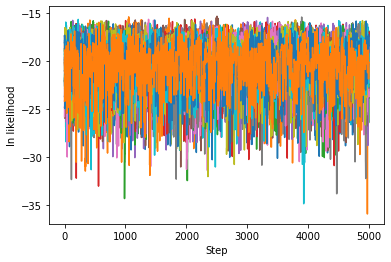

In [7]:
GalaxyDynamicsFromVc.plots.plot_lnlikelihoods(data_read['lnlikelihoods'])

We see in the previous plot that our walkers are generally well converged. However, in order to make sure that this is the case even further, we plot next their acceptance fractions, which should be around 0.3 (in a wide and approximated sense) if everything is working nicely.

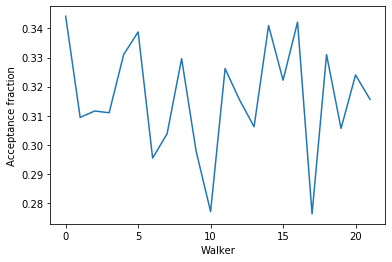

In [8]:
GalaxyDynamicsFromVc.plots.plot_acceptance_fraction(data_read['acceptance_fractions'])

The acceptance fraction also looks good.

Finally, we are going to plot a 2-dimension correlation plot of all the parameters of the model, including $R_\odot$.

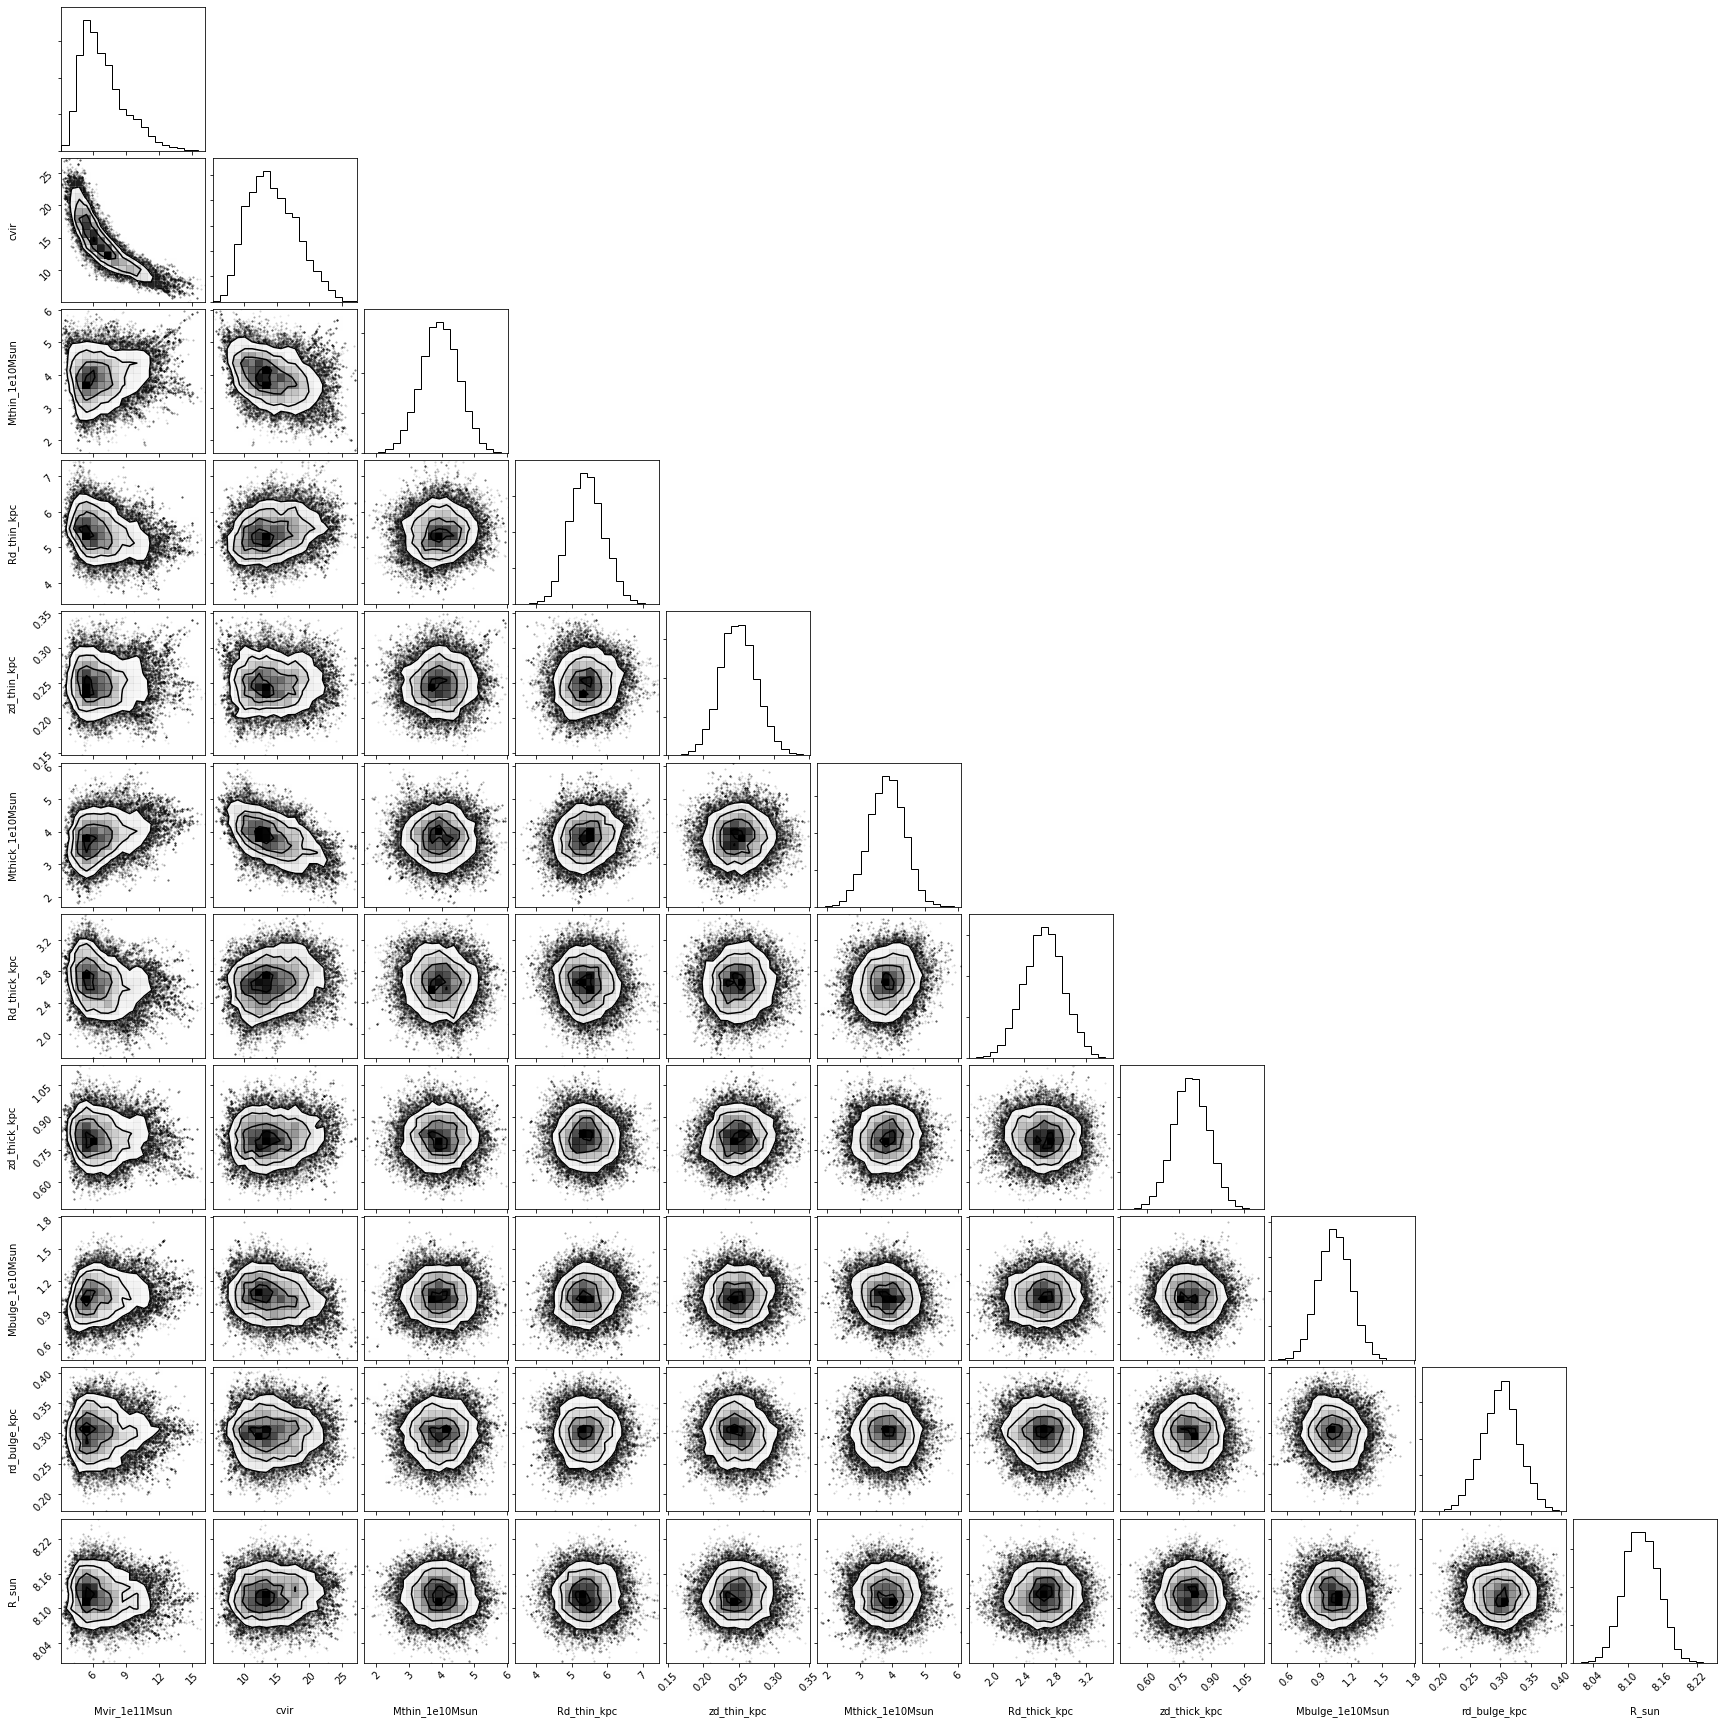

In [9]:
GalaxyDynamicsFromVc.plots.plot_corner_plot(data_read['chains'],data_read['variable_names'])

This also looks good, including an expected anti-correlation between the halo parameters Mvir\_1e11Msun and cvir.